In [1]:
#import numpy as np
from jax import grad
import jax.numpy as jnp
import jax
from jax import jit

from jax import random


import time, datetime

import matplotlib.pyplot as plt

from jax import vmap, jit

In [2]:
from jax.config import config
config.update("jax_enable_x64", True)

In [3]:
jax.default_backend()

'cpu'

# Using vmap

In [4]:
key = random.PRNGKey(0)

X = random.normal(key, (1000, 2))

Y = random.normal(key, (5000, 2))

l = 2.0

In [5]:

# def matern_kernel(x, y, length_scale):
#     r = jnp.sqrt(jnp.sum((x - y) ** 2))
#     #factor =r / length_scale
#     return (1 + jnp.sqrt(5)*r/length_scale + (5 / 3) * (r ** 2) / (length_scale ** 2)) * jnp.exp(-jnp.sqrt(5)*r/length_scale)

def matern_kernel(x, y, length_scale):
    r = jnp.sum((x - y) ** 2)
    #factor =r / length_scale
    return jnp.exp(-r/(2*length_scale**2))

# def matern_kernel(x, y, length_scale):
#     # Calculate the squared Euclidean distance
#     r_sq = jnp.sum((x - y) ** 2)
#     r = jnp.sqrt(r_sq)
    
#     # Calculate the Matérn 7/2 kernel
#     sqrt_14_r_by_rho = jnp.sqrt(14) * r / length_scale
#     kernel = (1 + sqrt_14_r_by_rho + (14.0 / 3.0) * r_sq / length_scale**2 +
#               (7.0 * sqrt_14_r_by_rho) / 15.0 * r**3 / length_scale**3)
#     kernel *= jnp.exp(-sqrt_14_r_by_rho)
    
#     return kernel




vmap_kernel_row = jax.vmap(matern_kernel, in_axes=(None, 0, None))
# Now we apply vmap to the result to vectorize over the rows of the first argument
vmap_kernel = jax.vmap(vmap_kernel_row, in_axes=(0, None, None))

In [6]:
start = time.time()
#m1 = kernel(X,X, l).block_until_ready()
m1= vmap_kernel(X,X, l).block_until_ready()
print(m1.shape)
end = time.time()

print(str(datetime.timedelta(seconds=end-start)))

(1000, 1000)
0:00:00.113844


In [7]:
import jax.numpy as jnp
from jax import vmap

def bump(x, epsilon, loc):
    condition = (loc - epsilon < x) & (x < loc + epsilon)
    return jnp.where(
        condition,
        jnp.exp(-1 / (1 - (x - loc) ** 2 / epsilon ** 2))/epsilon/0.4439938,
        0.0
    )
    
vmap_bump = jit(vmap(bump, in_axes=(0, None, None)))

In [8]:
loc = .0
epsilon = 1.0
bump(0, epsilon, loc)

Array(0.82856887, dtype=float64, weak_type=True)

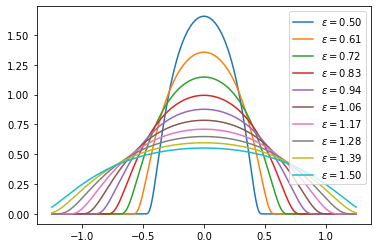

In [9]:
epsilon_values = jnp.linspace(0.5, 1.5, 10)

loc = 0.0
domain = jnp.linspace(-1.25, 1.25, 1000)

for epsilon in epsilon_values:
    plt.plot(domain, vmap_bump(domain, epsilon, loc), label = f"$\epsilon = {epsilon:.2f}$")
plt.legend()

In [10]:

# First vectorization over 'loc'
vectorized_over_loc = vmap(bump, in_axes=(None, None, 0))

# Second vectorization over 'epsilon'
vectorized_over_epsilon = vmap(vectorized_over_loc, in_axes=(None, 0, None))

# Final vectorization over 'x_values'
vmap_bump = vmap(vectorized_over_epsilon, in_axes=(0, None, None))

# Example usage with differently sized arrays for each parameter
x_values = jnp.array([0.1, 0.2, 0.3])  # m-sized array
epsilons = jnp.array([0.05, 0.1])      # n-sized array
locs = jnp.array([0.15, 0.25, 0.35, 0.45])  # d-sized array

# The result will be a d x n x m array
results = vmap_bump(x_values, epsilons, locs)

# Check the shape of the result to confirm it's d x n x m
assert results.shape == (len(x_values),  len(epsilons), len(locs))
print(results.shape)


(3, 2, 4)


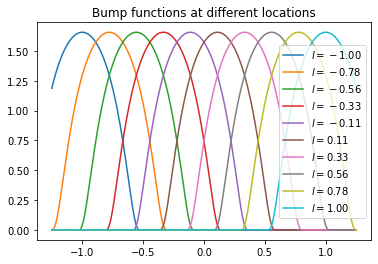

In [11]:
epsilon_values = jnp.array([0.5])
loc_values = jnp.linspace(-1.0, 1.0, 10)
domain = jnp.linspace(-1.25, 1.25, 1000)

bump_values = vmap_bump(domain, epsilon_values, loc_values)

for i, loc in enumerate(loc_values):
    plt.plot(domain, bump_values[:, 0, i], label = f"$l = {loc:.2f}$")
plt.legend()


plt.legend()
plt.title("Bump functions at different locations")
plt.show()

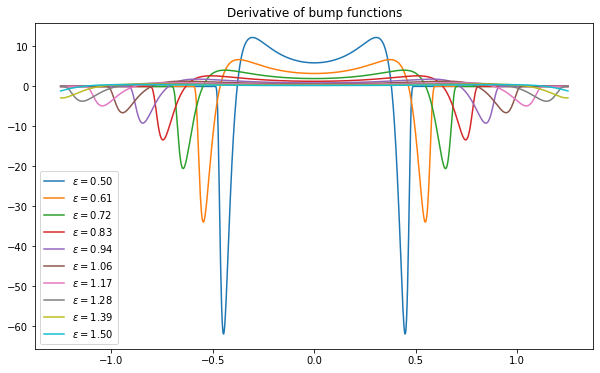

In [12]:

def bump_laplacian(x, epsilon, l):
    # Define the condition for the 'bump'
    condition = (l - epsilon < x) & (x < l + epsilon)
    
    # Define the numerator
    numerator = (
        2 * epsilon**2 *
        (3 * x**4 - 12 * l * x**3 + 18 * l**2 * x**2 - 12 * l**3 * x + 3 * l**4 - epsilon**4) *
        jnp.exp(-1 / (1 - ((x - l)**2 / epsilon**2)))
    )
    
    # Define the denominator
    denominator = (x**2 - 2 * l * x + l**2 - epsilon**2)**4
    
    # Use where to apply the condition
    result = jnp.where(condition, numerator / denominator, 0.0)
    
    return -result/epsilon

# Vectorize the bum_laplacian function
vmap_bump_laplacian = vmap(bump_laplacian, in_axes=(0, None, None))


epsilon_values =  jnp.linspace(0.5, 1.5, 10)

loc = 0.0
domain = jnp.linspace(-1.25, 1.25, 1000)

plt.figure(figsize=(10, 6))

for epsilon in epsilon_values:
    plt.plot(domain, vmap_bump_laplacian(domain, epsilon, loc), label = f"$\epsilon = {epsilon:.2f}$")
plt.legend()
plt.title("Derivative of bump functions")
plt.show()

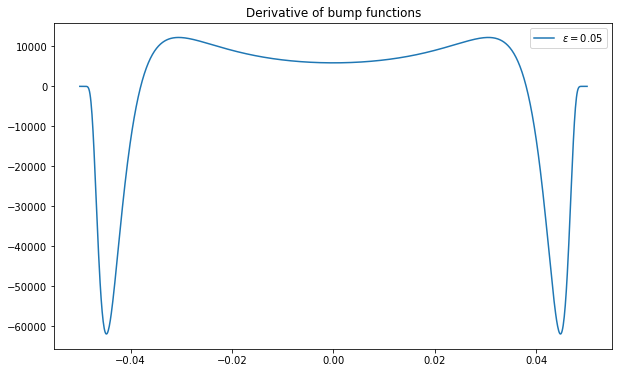

In [13]:

epsilon_values =  jnp.array([0.05])

loc = loc = jnp.array([+0.0])
domain = jnp.linspace(-epsilon_values[0], epsilon_values[0], 1000)

plt.figure(figsize=(10, 6))

for epsilon in epsilon_values:
    plt.plot(domain, vmap_bump_laplacian(domain, epsilon, loc), label = f"$\epsilon = {epsilon:.2f}$")
plt.legend()
plt.title("Derivative of bump functions")
plt.show()

# Using Gauss quadrature

In [14]:
length_scale = 1.0

epsilon_values =  jnp.array([0.05])
L = 2.0 # Lenght of the domain

loc_values = jnp.linspace(-1.0 + epsilon_values[0], 1.0 - epsilon_values[0],  int(L/(2*epsilon_values[0])))
bump_intervals =jnp.array([[l - epsilon_values[0], l + epsilon_values[0]] for l in loc_values]).T
support = jnp.array([loc_values - epsilon_values[0], loc_values + epsilon_values[0]]).T
N_test_functions = loc_values.shape[0]

In [15]:
from scipy.special import roots_legendre

# Define the order of the polynomial 

n_order = 1000
x_q, w_q = roots_legendre(n_order)

def root_interval(x_q, w_q, interval):
    # Defines the roots of the interval [a,b]
    a= interval[0]
    b= interval[1]
    return (b-a)/2*x_q + (b+a)/2, (b - a) / 2 * w_q

vmap_root_interval = vmap(root_interval, in_axes=(None,None,  0))
root_psi, w_psi = vmap_root_interval(x_q, w_q, support)

In [16]:

# Rescale the sample to be in the support of each bump function
#sample = jnp.squeeze((((sample*2*epsilon_values[0])[:, None]) +  loc_values[:, None] - epsilon_values[0])).T

# Check that the draws are only within the support
for i in range(N_test_functions):
    # print(support[i, 0], support[i, 1])
    # print(jnp.min(draw[i]), jnp.max(draw[i]))
    assert jnp.min(root_psi[i]) >= support[i, 0]
    assert jnp.max(root_psi[i]) <= support[i, 1]


In [17]:
bump_laplacian_vector = vmap(bump_laplacian, in_axes=(0, None, 0))
# Build the psi matrix
psi_matrix = bump_laplacian_vector(root_psi, epsilon_values, loc_values)
print(jnp.min(psi_matrix), jnp.max(psi_matrix))
psi_matrix = psi_matrix * w_psi
print(jnp.min(psi_matrix), jnp.max(psi_matrix))

-61992.0776673382 12239.679896519438
-4.41866849565474 1.5445479636653021


In [18]:
# Define a function that produces the kernel matrix evaluated at each pair of entries
# First, we vectorize the matern_kernel function over the entries of the first vector
vmapped_matern_kernel_first_vector = vmap(matern_kernel, in_axes=(0, None, None))
# Now, we vectorize the result over the entries of the second vector
vmapped_matern_kernel_matrix = vmap(vmapped_matern_kernel_first_vector, in_axes=(None, 0, None))

# Define the function that computes the kernel matrix for two vectors
def compute_K_pairwise(vector1, vector2, length_scale):
    # The resulting matrix will have shape (d, d)
    return vmapped_matern_kernel_matrix(vector1, vector2, length_scale)

K_test = compute_K_pairwise(root_psi[0], root_psi[1], length_scale)
print(K_test.shape)

@jit
def bilinear_form_K(x, y, points_1, points_2, normalize = False):
    # Create the kernel matrix 
    N = points_1.shape[0]
    M = points_2.shape[0]
    K = compute_K_pairwise(points_1, points_2, length_scale)
    if normalize:
        return jnp.dot(x, K @ y)/(N*M)
    else:
        return jnp.dot(x, K @ y)


i = 0
j = 0
bilinear_form_K(psi_matrix[i], psi_matrix[j], root_psi[i], root_psi[j])

(1000, 1000)


Array(0.59022318, dtype=float64)

In [19]:
# Vectorize bilinear_form_K over the rows of B for fixed rows of A
vmapped_bilinear_form_K_over_B = vmap(bilinear_form_K, in_axes=(None, 0, None, 0))

# Now, vectorize the result over the rows of A
vmapped_bilinear_form_K_over_A_and_B = vmap(vmapped_bilinear_form_K_over_B, in_axes=(0, None, 0, None))

# Define the function that applies vmapped_bilinear_form_K_over_A_and_B to compute the NxN result
@jit
def construct_theta(A, B):
    # A and B have shape (N, d)
    # The resulting matrix will have shape (N, N), where each (i, j) element is the result of
    # bilinear_form_K(A[i], A[j], B[i], B[j])
    return vmapped_bilinear_form_K_over_A_and_B(A, A, B, B)

theta = construct_theta(psi_matrix, root_psi)

print(theta.shape)

(20, 20)


In [20]:
# verify that our vmap is giving us the right answer
assert jnp.allclose(theta.T, theta)
for i in range(theta.shape[0]):
    for j in range(i, theta.shape[1]):
        assert jnp.allclose(theta[i,j], bilinear_form_K(psi_matrix[i], psi_matrix[j], root_psi[i], root_psi[j]))

In [21]:
# Check that the eigenvalues are positive
eigenvalues, eigenvectors = jnp.linalg.eigh(theta)
eigenvalues

Array([-1.06848363e-11, -9.80175620e-12, -7.69604255e-12, -5.44969335e-12,
       -1.78673662e-12, -1.48407681e-12,  2.98339372e-12,  4.60561856e-12,
        6.80384481e-12,  5.97550089e-11,  2.84512515e-09,  8.83295924e-08,
        3.17455963e-06,  6.50153977e-05,  1.58169289e-03,  1.92612398e-02,
        2.72014831e-01,  1.16283927e+00,  4.45021906e+00,  5.89849480e+00],      dtype=float64)

In [22]:
theta[0, :]

Array([ 0.59022318,  0.57556529,  0.53260654,  0.46430471,  0.37529809,
        0.27150211,  0.15960581,  0.04652068, -0.06116299, -0.15766065,
       -0.23837625, -0.30015428, -0.3413878 , -0.36198534, -0.36321379,
       -0.34744514, -0.31784199, -0.27801832, -0.23171034, -0.18248489],      dtype=float64)

In [23]:
# Comparing our answer against another integrator

i = 4
j = 19
f_intergrand = lambda x, y: bump_laplacian(x, epsilon_values[0], loc_values[i]) * matern_kernel(x, y, length_scale) * bump_laplacian(y, epsilon_values[0], loc_values[j])

l, m = 670,500
f_intergrand(root_psi[i, l], root_psi[j,m])

Array(21864323.75305361, dtype=float64)

In [24]:
psi_matrix_temp = bump_laplacian_vector(root_psi, epsilon_values, loc_values)
psi_matrix_temp[i,l]*psi_matrix_temp[j,m]*matern_kernel(root_psi[i, l], root_psi[j,m], length_scale)

Array(21864323.75305361, dtype=float64)

In [25]:
f_intergrand(root_psi[i, l], root_psi[j,m])

Array(21864323.75305361, dtype=float64)

In [26]:
bump_laplacian(root_psi[i, l], epsilon_values[0], loc_values[i]) , bump_laplacian(root_psi[j, m], epsilon_values[0], loc_values[j]) 

(Array(11016.99445521, dtype=float64), Array(5886.11458358, dtype=float64))

In [27]:
psi_matrix = bump_laplacian_vector(root_psi, epsilon_values, loc_values)
psi_matrix[i,l]*psi_matrix[j,m]*matern_kernel(root_psi[i, l], root_psi[j,m], length_scale)

Array(21864323.75305361, dtype=float64)

# Computing the negative laplacian of the kernel

In [30]:
from jax import hessian

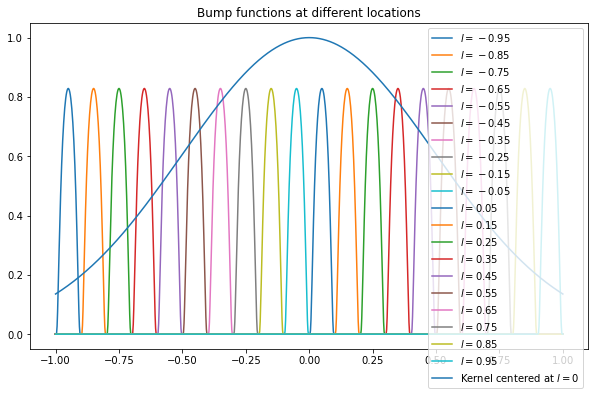

In [31]:
# Select bump functions which are 0 at the boundary
length_scale = 0.5

epsilon_values = jnp.array([0.05])
domain = jnp.linspace(-1,1, 1000)

L = 2.0 # Lenght of the domain
loc_values = jnp.linspace(-1.0 + epsilon_values[0], 1.0 - epsilon_values[0],  int(L/(2*epsilon_values[0])))

bump_values = vmap_bump(domain, epsilon_values, loc_values)

plt.figure(figsize = (10,6))
for i, loc in enumerate(loc_values):
    plt.plot(domain, bump_values[:, 0, i]*epsilon_values, label = f"$l = {loc:.2f}$")

plt.plot(domain, vmap_kernel(domain, jnp.array([0.0]), length_scale), label = f"Kernel centered at $l =0$")
plt.legend()


plt.legend()
plt.title("Bump functions at different locations")
plt.show()



In [32]:
@jit
def neg_laplacian_x(x,y, l ):
    hess = -hessian(matern_kernel, argnums = 0)(x,y,l)
    return jnp.sum(hess)

@jit
def double_neg_laplacian(x,y,l):
    hess = -hessian(neg_laplacian_x, argnums = 1)(x,y,l)

    hess = jnp.where(jnp.isnan(hess), 0.0, hess)
    return jnp.sum(hess)

In [33]:
double_neg_laplacian(domain[0], jnp.array([0.0]), length_scale), double_neg_laplacian(domain[0], domain[0], length_scale)

(Array(-10.82682266, dtype=float64), Array(48., dtype=float64))

In [34]:
# Create a vmap 

# Vectorize the gradient computation over the second argument y
vmap_hess_kernel_row = jit(jax.vmap(double_neg_laplacian, in_axes=(None, 0, None)))

# Vectorize the above result over the first argument x
vmap_kernel_double_laplacian = jit(jax.vmap(vmap_hess_kernel_row, in_axes=(0, None, None)))


In [35]:
K_delta_delta = vmap_kernel_double_laplacian(domain, domain, length_scale)

K_delta_delta

Array([[48.        , 47.99807617, 47.9923049 , ...,  0.89413656,
         0.88447   ,  0.87488653],
       [47.99807617, 48.        , 47.99807617, ...,  0.90388662,
         0.89413656,  0.88447   ],
       [47.9923049 , 47.99807617, 48.        , ...,  0.91372059,
         0.90388662,  0.89413656],
       ...,
       [ 0.89413656,  0.90388662,  0.91372059, ..., 48.        ,
        47.99807617, 47.9923049 ],
       [ 0.88447   ,  0.89413656,  0.90388662, ..., 47.99807617,
        48.        , 47.99807617],
       [ 0.87488653,  0.88447   ,  0.89413656, ..., 47.9923049 ,
        47.99807617, 48.        ]], dtype=float64)

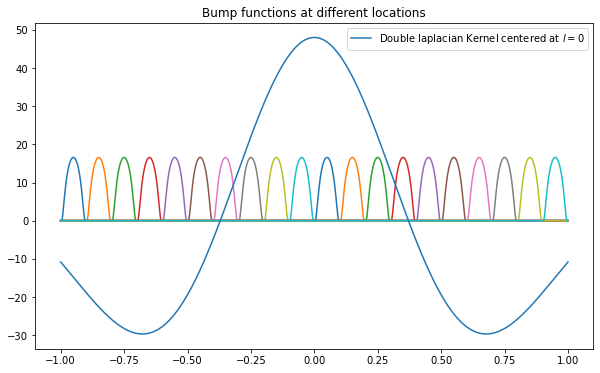

In [36]:
# Select bump functions which are 0 at the boundary
length_scale = 0.5

epsilon_values = jnp.array([0.05])
domain = jnp.linspace(-1,1, 1000)

L = 2.0 # Lenght of the domain
loc_values = jnp.linspace(-1.0 + epsilon_values[0], 1.0 - epsilon_values[0],  int(L/(2*epsilon_values[0])))

bump_values = vmap_bump(domain, epsilon_values, loc_values)

plt.figure(figsize = (10,6))
for i, loc in enumerate(loc_values):
    plt.plot(domain, bump_values[:, 0, i])

plt.plot(domain, vmap_kernel_double_laplacian(domain, jnp.array([0.0]), length_scale), label = f"Double laplacian Kernel centered at $l = 0$")
plt.legend()


plt.legend()
plt.title("Bump functions at different locations")
plt.show()

## Integrating using Gauss quadrature

In [122]:
from scipy.special import roots_legendre

# Define the order of the polynomial 

n_order = 1000

x_q, w_q = roots_legendre(n_order)

def root_interval(x_q, w_q, interval):
    # Defines the roots of the interval [a,b]
    a= interval[0]
    b= interval[1]
    return (b-a)/2*x_q + (b+a)/2, (b - a) / 2 * w_q

vmap_root_interval = vmap(root_interval, in_axes=(None,None,  0))
root_psi, w_psi = vmap_root_interval(x_q, w_q, support)

In [123]:
support = jnp.array([loc_values - epsilon_values[0], loc_values + epsilon_values[0]]).T

root_psi, w_psi = vmap_root_interval(x_q, w_q, support)

bump_vector = vmap(bump, in_axes=(0, None, 0))
# Build the psi matrix
psi_matrix = bump_vector(root_psi, epsilon_values, loc_values)
print(jnp.min(psi_matrix), jnp.max(psi_matrix))
psi_matrix = psi_matrix * w_psi
print(jnp.min(psi_matrix), jnp.max(psi_matrix))

0.0 16.571336553446656
0.0 0.0026017150681014556


In [124]:
root_psi.shape, w_psi.shape

((20, 1000), (20, 1000))

In [125]:
vmap_matern_laplacian_first_vector = jit(vmap(double_neg_laplacian, in_axes=(0, None, None)))
# Now, we vectorize the result over the entries of the second vector
vmap_matern_laplacian_kernel_matrix = jit(vmap(vmap_matern_laplacian_first_vector, in_axes=(None, 0, None)))

#  Define the function that computes the kernel matrix for two vectors
def compute_K_double_laplacian_pairwise(vector1, vector2, length_scale):
    # The resulting matrix will have shape (d, d)
    return vmap_matern_laplacian_kernel_matrix(vector1, vector2, length_scale)


@jit
def bilinear_form_K(x, y, points_1, points_2, normalize = False):
    # Create the kernel matrix 
    N = points_1.shape[0]
    M = points_2.shape[0]
    K = compute_K_double_laplacian_pairwise(points_1, points_2, length_scale)
    
    if normalize:
        return jnp.dot(x, K @ y)/(N*M)
    else:
        return jnp.dot(x, K @ y)


i = 0
j = 0
bilinear_form_K(psi_matrix[i], psi_matrix[j], root_psi[i], root_psi[j])

Array(47.62231625, dtype=float64)

In [126]:
# Vectorize bilinear_form_K over the rows of B for fixed rows of A
vmapped_bilinear_form_K_over_B = vmap(bilinear_form_K, in_axes=(None, 0, None, 0))

# Now, vectorize the result over the rows of A
vmapped_bilinear_form_K_over_A_and_B = vmap(vmapped_bilinear_form_K_over_B, in_axes=(0, None, 0, None))

# Define the function that applies vmapped_bilinear_form_K_over_A_and_B to compute the NxN result
@jit
def construct_theta(A, B):
    # A and B have shape (N, d)
    # The resulting matrix will have shape (N, N), where each (i, j) element is the result of
    # bilinear_form_K(A[i], A[j], B[i], B[j])
    return vmapped_bilinear_form_K_over_A_and_B(A, A, B, B)

theta = construct_theta(psi_matrix, root_psi)

print(theta.shape)

(20, 20)


In [127]:
# verify that our vmap is giving us the right answer
assert jnp.allclose(theta.T, theta)
for i in range(theta.shape[0]):
    for j in range(i, theta.shape[1]):
        assert jnp.allclose(theta[i,j], bilinear_form_K(psi_matrix[i], psi_matrix[j], root_psi[i], root_psi[j]))

In [128]:
# Check that the eigenvalues are positive
eigenvalues, eigenvectors = jnp.linalg.eigh(theta)
eigenvalues

Array([-5.43042133e-14,  3.60197643e-15,  6.65634179e-13,  2.90158696e-11,
        1.04114403e-09,  2.46224244e-08,  5.55928847e-07,  8.63051113e-06,
        1.34921734e-04,  1.45409847e-03,  1.62444296e-02,  1.22390714e-01,
        9.64982853e-01,  4.71257368e+00,  2.46509225e+01,  3.14207449e+01,
        1.05003490e+02,  1.51924543e+02,  2.99334161e+02,  3.34294673e+02],      dtype=float64)

In [129]:
theta[0, :]

Array([ 47.62231625,  42.98422839,  30.31827826,  12.94302655,
        -4.85614297, -19.16483787, -27.50945303, -29.31619189,
       -25.69908984, -18.77874694, -10.86391185,  -3.79826722,
         1.36468384,   4.35797223,   5.48054488,   5.30524201,
         4.43009464,   3.32807003,   2.29593674,   1.47167785],      dtype=float64)

In [130]:
for i in range(theta.shape[0]):
    print(theta[i,i], double_neg_laplacian(loc_values[i], loc_values[i], length_scale))


47.62231625469771 48.0
47.62231625469771 48.0
47.62231625469771 48.0
47.62231625469771 48.0
47.62231625469771 48.0
47.6223162546977 48.0
47.62231625469769 48.0
47.62231625469767 48.0
47.622316254697694 48.0
47.62231625469769 48.0
47.622316254697665 48.0
47.622316254697715 48.0
47.62231625469768 48.0
47.62231625469769 48.0
47.62231625469769 48.0
47.62231625469771 48.0
47.62231625469771 48.0
47.62231625469771 48.0
47.62231625469771 48.0
47.62231625469771 48.0


# Using a MC approach

In [48]:
N_samples = 1000

In [112]:
support = jnp.array([loc_values - epsilon_values[0], loc_values + epsilon_values[0]]).T


# Instead of using Gauss quadrature points, we will use random samples 
key = random.PRNGKey(0)
x_q = random.uniform(key, (N_test_functions, N_samples))*2*epsilon_values[0] +  loc_values[:, None] - epsilon_values[0]
root_psi = x_q

# The weights are all equal to 1/N_samples
w_psi = jnp.ones((N_test_functions, N_samples))/N_samples
#root_psi, w_psi = vmap_root_interval(x_q, w_q, support)

bump_vector = vmap(bump, in_axes=(0, None, 0))
# Build the psi matrix
psi_matrix = bump_vector(root_psi, epsilon_values, loc_values)
print(jnp.min(psi_matrix), jnp.max(psi_matrix))
psi_matrix = psi_matrix /1000
print(jnp.min(psi_matrix), jnp.max(psi_matrix))

0.0 16.5713773577762
0.0 0.0165713773577762


In [113]:
w_psi.shape, psi_matrix.shape

((20, 1000), (20, 1000))

In [114]:
vmap_matern_laplacian_first_vector = jit(vmap(double_neg_laplacian, in_axes=(0, None, None)))
# Now, we vectorize the result over the entries of the second vector
vmap_matern_laplacian_kernel_matrix = jit(vmap(vmap_matern_laplacian_first_vector, in_axes=(None, 0, None)))

#  Define the function that computes the kernel matrix for two vectors
def compute_K_double_laplacian_pairwise(vector1, vector2, length_scale):
    # The resulting matrix will have shape (d, d)
    return vmap_matern_laplacian_kernel_matrix(vector1, vector2, length_scale)


@jit
def bilinear_form_K(x, y, points_1, points_2, ):
    # Create the kernel matrix 
    N = points_1.shape[0]
    M = points_2.shape[0]

    K = compute_K_double_laplacian_pairwise(points_1, points_2, length_scale)

    

    return jnp.dot(x, K @ y)


i = 0
j = 0
bilinear_form_K(psi_matrix[i], psi_matrix[j], root_psi[i], root_psi[j])

Array(4866.68018125, dtype=float64)

In [116]:
# Vectorize bilinear_form_K over the rows of B for fixed rows of A
vmapped_bilinear_form_K_over_B = vmap(bilinear_form_K, in_axes=(None, 0, None, 0))

# Now, vectorize the result over the rows of A
vmapped_bilinear_form_K_over_A_and_B = vmap(vmapped_bilinear_form_K_over_B, in_axes=(0, None, 0, None))

# Define the function that applies vmapped_bilinear_form_K_over_A_and_B to compute the NxN result
@jit
def construct_theta(A, B):
    # A and B have shape (N, d)
    # The resulting matrix will have shape (N, N), where each (i, j) element is the result of
    # bilinear_form_K(A[i], A[j], B[i], B[j])
    return vmapped_bilinear_form_K_over_A_and_B(A, A, B, B)

theta = construct_theta(psi_matrix, root_psi)

print(theta.shape)

(20, 20)


In [103]:
# verify that our vmap is giving us the right answer
assert jnp.allclose(theta.T, theta)
for i in range(theta.shape[0]):
    for j in range(i, theta.shape[1]):
        assert jnp.allclose(theta[i,j], bilinear_form_K(psi_matrix[i], psi_matrix[j], root_psi[i], root_psi[j]))

In [104]:
# Check that the eigenvalues are positive
eigenvalues, eigenvectors = jnp.linalg.eigh(theta)
eigenvalues

Array([1.60152068e+00, 4.48351773e+00, 1.24920027e+01, 1.85284780e+01,
       2.44587499e+01, 4.08527965e+01, 4.77696198e+01, 5.44727787e+01,
       5.61414788e+01, 6.88431549e+01, 7.66821331e+01, 8.67753561e+01,
       1.29228209e+02, 4.96156974e+02, 2.42402440e+03, 3.12124450e+03,
       1.03165924e+04, 1.49135449e+04, 2.93136533e+04, 3.29390752e+04],      dtype=float64)

In [105]:
theta[0, :]

Array([ 4866.68018125,  4290.48025694,  3023.40367184,  1318.26582905,
        -487.75763301, -1864.72894629, -2725.27466501, -2882.77315576,
       -2589.00099105, -1871.61600547, -1114.61537596,  -386.39142622,
         129.33149848,   423.90819146,   559.84112931,   528.87042448,
         448.82720445,   330.06397022,   230.24915158,   145.17025416],      dtype=float64)

In [106]:
for i in range(theta.shape[0]):
    print(theta[i,i], double_neg_laplacian(loc_values[i], loc_values[i], length_scale))


4866.680181251563 48.0
4696.505031216258 48.0
4758.056597634341 48.0
4727.770290350735 48.0
4866.154015893451 48.0
4676.207038973682 48.0
4666.236037446599 48.0
4585.019370082448 48.0
4794.345487266916 48.0
4706.280036600823 48.0
4899.2792707527005 48.0
4499.042446859835 48.0
4758.221702437911 48.0
4557.311314302898 48.0
4952.15579728121 48.0
4672.505934910661 48.0
4756.0782946097415 48.0
4572.284381212395 48.0
4719.280812558775 48.0
4417.207538185025 48.0


In [99]:
theta[i,i]/10**6

Array(4417.20753819, dtype=float64)

In [98]:
10**3

1000

# Using a monte carlo approach

In [51]:
length_scale = 1.0


epsilon_values =  jnp.array([0.05])
L = 2.0 # Lenght of the domain

loc_values = jnp.linspace(-1.0 + epsilon_values[0], 1.0 - epsilon_values[0],  int(L/(2*epsilon_values[0])))
support = jnp.array([loc_values - epsilon_values[0], loc_values + epsilon_values[0]]).T
N_test_functions = loc_values.shape[0]


In [52]:
from scipy.stats import qmc
d = 1
sampler = qmc.Sobol(d=1)

n_draws = int(jnp.ceil(jnp.log2(1024))) # the number of draws is 2**n_draws
sample = sampler.random_base2(n_draws) # this sample is between 0 and 1
sample.shape

key = random.PRNGKey(0)
N_samples =2500
sample = random.uniform(key, (N_test_functions, N_samples))*2*epsilon_values[0] +  loc_values[:, None] - epsilon_values[0]

# Rescale the sample to be in the support of each bump function
#sample = jnp.squeeze((((sample*2*epsilon_values[0])[:, None]) +  loc_values[:, None] - epsilon_values[0])).T

print(sample.shape)

# Check that the draws are only within the support
for i in range(N_test_functions):
    # print(support[i, 0], support[i, 1])
    # print(jnp.min(draw[i]), jnp.max(draw[i]))
    assert jnp.min(sample[i]) >= support[i, 0]
    assert jnp.max(sample[i]) <= support[i, 1]


<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


(20, 2500)


In [53]:
bump_laplacian_vector = vmap(bump_laplacian, in_axes=(0, None, 0))
# Build the psi matrix
psi_matrix = bump_laplacian_vector(sample, epsilon_values, loc_values)

In [54]:
# Define a function that produces the kernel matrix evaluated at each pair of entries
# First, we vectorize the matern_kernel function over the entries of the first vector
vmapped_matern_kernel_first_vector = vmap(matern_kernel, in_axes=(0, None, None))
# Now, we vectorize the result over the entries of the second vector
vmapped_matern_kernel_matrix = vmap(vmapped_matern_kernel_first_vector, in_axes=(None, 0, None))

# Define the function that computes the kernel matrix for two vectors
def compute_K_pairwise(vector1, vector2, length_scale):
    # The resulting matrix will have shape (d, d)
    return vmapped_matern_kernel_matrix(vector1, vector2, length_scale)

K_test = compute_K_pairwise(sample[0], sample[1], length_scale)
print(K_test.shape)

def bilinear_form_K(x, y, points_1, points_2):
    # Create the kernel matrix 
    N = points_1.shape[0]
    M = points_2.shape[0]
    K = compute_K_pairwise(points_1, points_2, length_scale)

    return jnp.dot(x, K @ y)/(N*M)

i = 0
j = 0
bilinear_form_K(psi_matrix[i], psi_matrix[j], sample[i], sample[j])

(2500, 2500)


Array(406660.05618376, dtype=float64)

In [55]:
# Vectorize bilinear_form_K over the rows of B for fixed rows of A
vmapped_bilinear_form_K_over_B = vmap(bilinear_form_K, in_axes=(None, 0, None, 0))

# Now, vectorize the result over the rows of A
vmapped_bilinear_form_K_over_A_and_B = vmap(vmapped_bilinear_form_K_over_B, in_axes=(0, None, 0, None))

# Define the function that applies vmapped_bilinear_form_K_over_A_and_B to compute the NxN result
@jit
def construct_theta(A, B):
    # A and B have shape (N, d)
    # The resulting matrix will have shape (N, N), where each (i, j) element is the result of
    # bilinear_form_K(A[i], A[j], B[i], B[j])
    return vmapped_bilinear_form_K_over_A_and_B(A, A, B, B)

theta = construct_theta(psi_matrix, sample)

print(theta.shape)

(20, 20)


In [56]:
# verify that our vmap is giving us the right answer
assert jnp.allclose(theta.T, theta)
for i in range(theta.shape[0]):
    for j in range(i, theta.shape[1]):
        assert jnp.allclose(theta[i,j], bilinear_form_K(psi_matrix[i], psi_matrix[j], sample[i], sample[j]))

KeyboardInterrupt: 

In [57]:
# Check that the eigenvalues are positive
eigenvalues, eigenvectors = jnp.linalg.eigh(theta)
eigenvalues

Array([-1.70913043e+04, -1.29346702e+04, -1.20506382e+04, -6.56186652e+03,
       -5.12491968e+03, -3.86341692e+03, -2.55638439e+03, -1.36060951e+03,
        1.59803217e+03,  3.88429045e+03,  6.84348710e+03,  8.15872040e+03,
        9.31678465e+03,  1.71581900e+04,  2.03089473e+04,  2.42423571e+04,
        3.62035176e+04,  1.57109413e+05,  8.11545535e+05,  2.27067157e+06],      dtype=float64)

In [58]:
theta[0, :]

Array([ 406660.05618376, -254221.52391768,  198160.85482699,
        241596.93387268, -234651.41026294,   67058.5290147 ,
        105486.97232523,   57387.31554612,   32732.24658001,
        115606.93597618,  180883.60190323,  -84562.15169488,
        -65745.73857102,   73509.73887697,  -53380.18977051,
        139458.73079565,  -73650.54529081,   79400.12844896,
          3899.56810644,  -51207.12157881], dtype=float64)

In [104]:
# Comparing our answer against another integrator

i = 1
j = 10
f_intergrand = lambda x, y: bump_laplacian(x, epsilon_values[0], loc_values[i]) * matern_kernel(x, y, length_scale) * bump_laplacian(y, epsilon_values[0], loc_values[j])

In [105]:
import scipy
scipy.__version__

'1.11.3'

In [106]:
def f_intergrand(points):
    print(points.shape)
    x = points[0, :]
    y = points[1, :]
    
    return bump_laplacian(x, epsilon_values[0], loc_values[i]) * matern_kernel(x, y, length_scale) * bump_laplacian(y, epsilon_values[0], loc_values[j])

In [107]:
x = jnp.array([1,2,3])
y = jnp.array([3,4,5])

test_points = jnp.stack([x,y])
test_points.shape
#vmap_kernel_row(x, y, length_scale), 

f_intergrand(test_points)

(2, 3)


Array([0., 0., 0.], dtype=float64)

In [108]:
from scipy.integrate import qmc_quad
a =  jnp.array([loc_values[i] - epsilon_values[0], loc_values[j] - epsilon_values[0]])
b = jnp.array([loc_values[i] + epsilon_values[0], loc_values[j] + epsilon_values[0]])
#qmc_quad(f_intergrand,a, b)
a.shape, b.shape

((2,), (2,))

In [109]:
i = 0
j = 0

a =  jnp.array([loc_values[i] - epsilon_values[0], loc_values[j] - epsilon_values[0]])
b = jnp.array([loc_values[i] + epsilon_values[0], loc_values[j] + epsilon_values[0]])
def f_intergrand(points):
    #print(points.shape)
    if len(points.shape) == 1:
        x = points[0]
        y = points[1]
        return bump_laplacian(x, epsilon_values[0], loc_values[i]) * matern_kernel(x, y, length_scale) * bump_laplacian(y, epsilon_values[0], loc_values[j])
    else:
        x = points[0, :]
        y = points[1, :]
    
    return bump_laplacian(x, epsilon_values[0], loc_values[i]) * matern_kernel(x, y, length_scale) * bump_laplacian(y, epsilon_values[0], loc_values[j])

qmc_quad(f_intergrand,a, b, n_estimates=50, n_points = 1000)

QMCQuadResult(integral=3522.1411734827357, standard_error=1905.9936726886826)

In [110]:
theta[i,j]

Array(153667.22899739, dtype=float64)

In [48]:
import numpy as np

from scipy import stats

dim = 8

mean = np.zeros(dim)

cov = np.eye(dim)

def func(x):

    # `multivariate_normal` expects the _last_ axis to correspond with

    # the dimensionality of the space, so `x` must be transposed

    return stats.multivariate_normal.pdf(x.T, mean, cov)



a = jnp.zeros(dim)

b = jnp.ones(dim)

rng =np.random.default_rng()

qrng = stats.qmc.Halton(d=dim, seed=rng)

n_estimates = 8

res = qmc_quad(func, a, b, n_estimates=n_estimates, qrng=qrng)

res

QMCQuadResult(integral=0.00018421354886768862, standard_error=8.520956249004299e-08)

In [50]:
a.shape

(8,)